In [2]:
import matplotlib.pyplot as plt
import numpy as np
import gym
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense 
import tensorflow_probability as tfp # require tensorflow >= 2.6

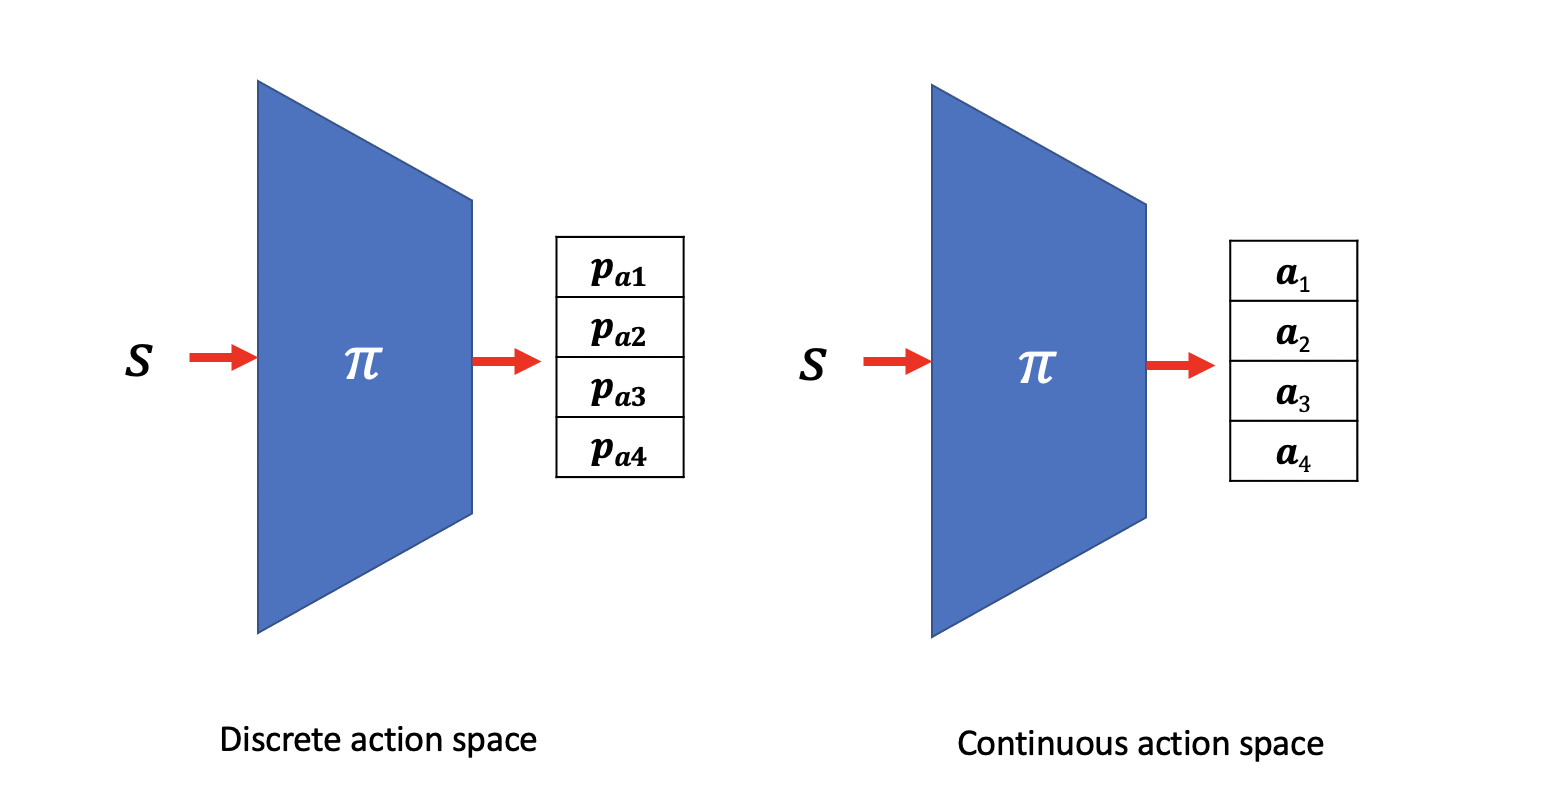

In [3]:
from IPython.display import Image
Image(filename='pg1.png')

In [5]:
#폴리시 네트워크 클레스
# 우리는 discreate action 을 이용한 폴리시를 2-layered fully connected layer 로 만들어보자.
# 인풋: 스테이트 벡터
# 아웃풋: 엑션별 확률 (categorical distribution of each action.) 
class PolicyGradientNetwork(keras.Model): #drives from keras.Model
    def __init__(self, n_actions, fc1_dims=256, fc2_dims=256):
        super(PolicyGradientNetwork, self).__init__() # call our super constructor
        self.fc1_dims = fc1_dims # save our member variables
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions # We use discrete lunar lander. so n_actions is integer
        self.fc1 = Dense(self.fc1_dims, activation='relu')  # output dimension: fc_dims, input dimension: infered 
        self.fc2 = Dense(self.fc2_dims, activation='relu')
        self.pi = Dense(n_actions, activation='softmax') # categorical distribution of each action.
  
    #To call the policy network. 
    def call(self, state):
        value = self.fc1(state) # pass the state as the input to first fully connected layer.
        value = self.fc2(value) # pass that output to the second fully connected layer. 
        pi = self.pi(value) # pass that through the final layer of pi.
        return pi # return policy pi

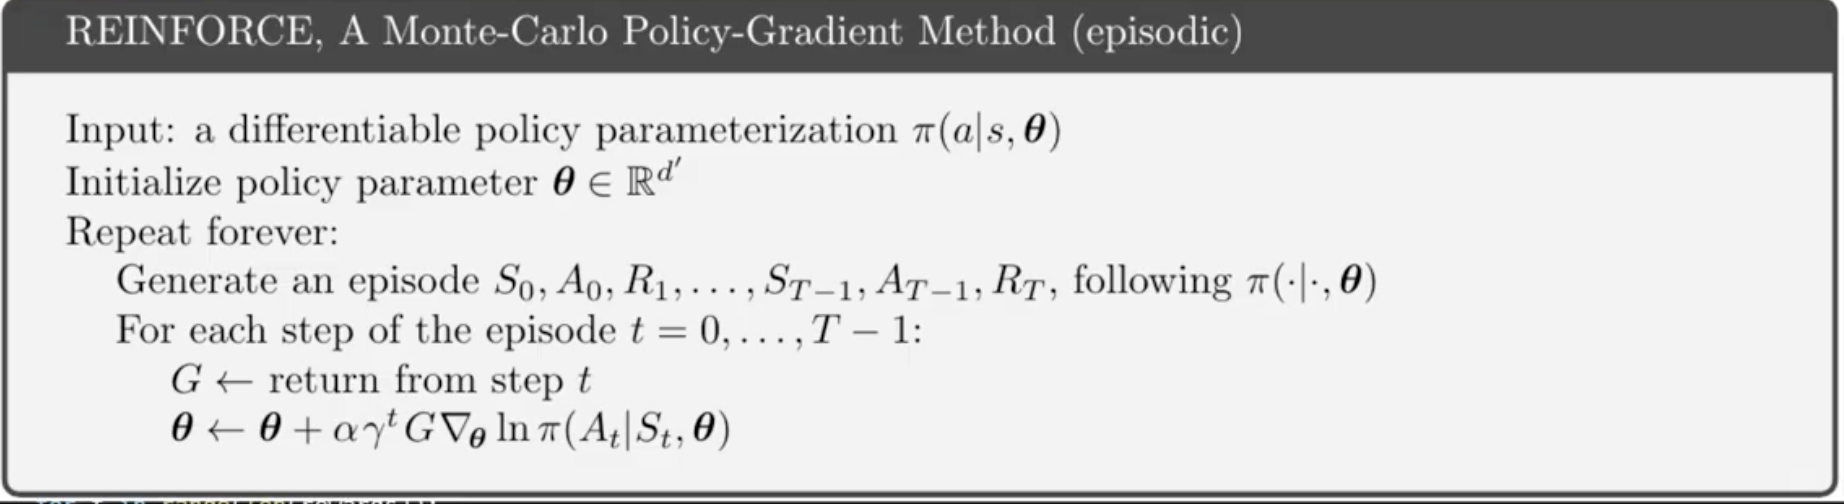

In [6]:
Image(filename='REINFORCE.png')

In [11]:
class Agent:
    # alpha: learning rate
    # gamma: discounted rate (for the cummulated sum of discounted reward)
    def __init__(self, alpha=0.003, gamma=0.99, n_actions=4,
                 layer1_size=256, layer2_size=256):
        
        self.gamma = gamma # save our member variables
        self.lr = alpha
        self.n_actions = n_actions
        # Policy Gradient 는 트레제토리를 다 뽑은다음에, (Expected Cumulated reward: (loss) 가 멕스가 되도록) gradient ascent 를 하기때문에
        # 모든 트레제토리의 state action reward 를 저장할 메모리를 디파인 해 주어야 한다. 
        self.state_memory = [] # our memory will be handled by series of lists
        self.action_memory = []
        self.reward_memory = []
        # 앞에서 디파인한 PolicyGradientNetwork Class 를 가져온다
        self.policy = PolicyGradientNetwork(n_actions=n_actions)
        self.policy.compile(optimizer=Adam(learning_rate=self.lr))

    # Function to choose to handle the action    
    # input 인 observation 을 넣으면, policy network 에서 가장 높은 확률로 나오는 action 을 예측하는 펑션
    def choose_action(self, observation):
        # convert numpy array of observation to tensor
        #[observation] <-- add the batch dimension
        state = tf.convert_to_tensor([observation], dtype=tf.float32) 
        # Pass that state to the policy network
        probs = self.policy(state) # give the probability of distribution to choose the action
        # make the output to the cathegorical distribution
        # because action space is discrete
        action_probs = tfp.distributions.Categorical(probs=probs) 
        # sample action from categorical distribution
        # 각 엑션의 확률이 아웃풋으로 나오므로,
        # 그 확률에서 아웃풋 엑션을 샘플링 해야함.
        action = action_probs.sample()

        return action.numpy()[0] # should change it back to numpy array to make it work in open-ai gym
  
    # Function to store transition to the  agent's memory of the current episode
    # We need the whole trajectory for policy gradient
    def store_transition(self, observation, action, reward):
        # simple append operation of state, aciton and reward
        self.state_memory.append(observation)
        self.action_memory.append(action)
        self.reward_memory.append(reward)
        
    # Function to perform agent's learning 
    # gradient ascent 를 수행하는 트레이닝 펑션
    # 위 알고리즘에서 아래 두줄
    def learn(self):
        # convert action of array to tensorflow tensor
        actions = tf.convert_to_tensor(self.action_memory, dtype=tf.float32)
        rewards = np.array(self.reward_memory)

        # Calculate the discounted sum of future rewards follows each timestep
        # We have memory of s,a,r,s'
        # So we go through each timestep from start to end, and calculate 
        # G_sum which is the discounted sum of future rewards follows each timestep
        # 각 타임스텝에서의 모든 (디스카운트 된) 리턴을 저장해둔다.
        # rewards = r_0, r_1, r_2, r_3, r_4, r_5
        # G       = R_0, R_1, R_2, R_3, R_4, R_5 (R_t means discounted cumulated future rewards from time t)
        G = np.zeros_like(rewards)
        for t in range(len(rewards)):
            G_sum = 0
            discount = 1
            for k in range(t, len(rewards)):
                G_sum += rewards[k] * discount
                discount *= self.gamma
            G[t] = G_sum
        
        # Handle the calculation of the gradient 
        # tf.GradientTape() : tf implementation to handle specific gradient 
        # it helps to calculate grandient at each time step of the episode
        # This is new to tensorflow>=2.0 
        # !!!!!!!!!!!이부분이 까다로움
        # 텐서플로우에서 제공하는 그레디언트 테잎을 이용해서, 우리가 원하는 변수에대해 특정 베리어블을 미분할 수 있다. 
        # y= x*x #f(x)
        # with tf.GradientTape() as g:
        #    g.watch(x)
        # dy_dx = g.gradient(y, x)  # dy_dx = 2 * x
        with tf.GradientTape() as tape:
            loss = 0
            # Go back through the memomry.
            # idx: index
            # g: the discounted reward
            # state : states are sampled from memory
            for idx, (g, state) in enumerate(zip(G, self.state_memory)):
                state = tf.convert_to_tensor([state], dtype=tf.float32) # convert state to tensor
                # feed state to the policy network
                probs = self.policy(state)
                # calculate action of the probabilty as categorical distribution
                action_probs = tfp.distributions.Categorical(probs=probs)
                # calculate our log prob
                log_prob = action_probs.log_prob(actions[idx])
                # log_prob has batch dimension so we do tf.squeeze to make it scalar quantity
                # By default, tf performs gradient discent 
                # But we don't want to find the minima (we do gradient ascent)
                # That's why we put minus sign here in loss
                # here, loss is the expected reward
                loss += -g * tf.squeeze(log_prob) 

        #wrap up our gradient 
        gradient = tape.gradient(loss, self.policy.trainable_variables) #self.policy.trainable_variables: theta
        # Apply those gradient to policy network
        self.policy.optimizer.apply_gradients(zip(gradient, self.policy.trainable_variables))

        # At the end of episode, we zero out our memory
        self.state_memory = []
        self.action_memory = []
        self.reward_memory = []

In [13]:
def plotLearning(scores, filename, x=None, window=5):   
    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
	    running_avg[t] = np.mean(scores[max(0, t-window):(t+1)])
    if x is None:
        x = [i for i in range(N)]
    plt.ylabel('Score')       
    plt.xlabel('Game')                     
    plt.plot(x, running_avg)
    plt.savefig(filename)

2022-01-04 01:52:30.508171: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


episode:  0 score: -101.4 average score -101.4
episode:  1000 score: -85.7 average score -100.7
episode:  2000 score: -53.5 average score 74.8
episode:  3000 score: 146.2 average score 131.2
episode:  4000 score: 1.9 average score 81.3
episode:  5000 score: 15.6 average score 126.0
episode:  6000 score: 235.8 average score 116.5
episode:  7000 score: 256.1 average score 171.7
episode:  8000 score: 150.0 average score 143.9
episode:  9000 score: 227.6 average score 141.3


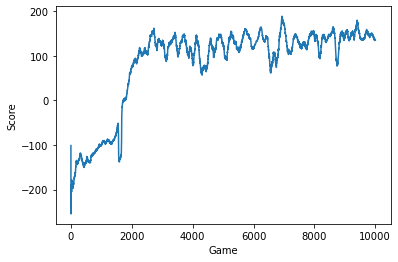

In [14]:
agent = Agent(alpha=0.0005,  gamma=0.99, n_actions=4)

env = gym.make('LunarLander-v2')
# instantiate score history (thats how we keep track of our scores)
score_history = []

num_episodes = 10000

#repeat episode
for i in range(num_episodes):
    done = False
    score = 0
    observation = env.reset()
    while not done:
        #choose action based on the observation
        action = agent.choose_action(observation) 
        observation_, reward, done, info = env.step(action)
        # Store transition to the memory                                       
        agent.store_transition(observation, action, reward)
        # update next state as new state
        observation = observation_
        # add reward 
        score += reward
    # append score to agent's score history
    score_history.append(score)

    # start learn (train)
    agent.learn()
    # Why learn located once at the every end of the episode? 
    # This is Monte Carlo method: 
    # we learn how to play the game by playing the game
    # Agent has no idea how the game works initially
    # just it learns the rule by interact with it.
    # The learning is conducted at the end of the every episodes 
    # So calculation of learn function iterates whole state memories 
    # So learning takes place once at the every end of the episode.
    # (Temporal difference learning like Q-learning or Actor-critic learns every time steps in the episodes)
    
    # calculate average score over previous 100 games
    avg_score = np.mean(score_history[-100:])
    # We print some information to our terminal
    if i %1000 == 0: 
        print('episode: ', i,'score: %.1f' % score,
        'average score %.1f' % avg_score)

filename = 'lunar-lander.png'
plotLearning(score_history, filename=filename, window=100) #window of 100 games